# Extra task: uncertainty
Use Monte Carlo Dropout to estimate classification confidence. 
Compare dropout to an ensemble of CNN networks (e.g.: do individual dropout subnetworks point to the same, or different local minima?)

Great article to get familiar with the topic: [link](https://medium.com/@ciaranbench/monte-carlo-dropout-a-practical-guide-4b4dc18014b5).

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import matplotlib.pyplot as plt
from keras.api.utils import image_dataset_from_directory
import numpy as np
import tensorflow as tf
import keras
from keras.api.optimizers import SGD
from keras.api.callbacks import EarlyStopping, TensorBoard
from keras.api.optimizers.schedules import ExponentialDecay
from keras.api.losses import CategoricalCrossentropy
from keras.api.metrics import CategoricalAccuracy

DATA_PATH = os.path.join(os.getcwd(), "..", "data")
MODEL_PATH = os.path.join(os.getcwd(), "..", "models")
LOG_DIR = os.path.join(os.getcwd(), "..", "logs")

2024-12-18 13:38:56.717042: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 13:38:56.727707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734525536.742464   11212 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734525536.746677   11212 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 13:38:56.761628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
dataset_path = os.path.join(DATA_PATH, "kaggle-speech-recognition")
batch_size = 128
class_names = next(os.walk(os.path.join(dataset_path, "train")))[1]
class_dict = dict(zip(class_names, range(len(class_names))))

# ds_train: tf.data.Dataset = image_dataset_from_directory(os.path.join(dataset_path, "train"), color_mode="grayscale",
#                                         label_mode="categorical", batch_size=batch_size, class_names=class_names,
#                                         seed=42, validation_split=0.0)
ds_valid: tf.data.Dataset  = image_dataset_from_directory(os.path.join(dataset_path, "validation"), color_mode="grayscale",
                                        label_mode="categorical", batch_size=batch_size, class_names=class_names,
                                        seed=42, validation_split=0.0)

# ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

Found 6798 files belonging to 30 classes.


I0000 00:00:1734525539.048672   11212 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


The architecture of the model is AlexNet, since by convention it has dropout layers in the dense tail. Therefore it fits nicely with out goal here.

In [3]:
def model(
        normalization_layer = None,
        dropout_rate = 0.5,
        input_shape = (256, 256),
        batch_size = 128
):
    inputs = keras.layers.Input(shape=input_shape, batch_size=batch_size)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    if normalization_layer is not None:
        x = normalization_layer(x)
    x = keras.layers.RandomCrop(height=227, width=227)(x)

    # Convolutional layers
    # Instead of 11x11 stride 4 we are going to use subsequent 3x3 layers
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2)(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2)(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(3, 3))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(x)

    x = keras.layers.Conv2D(256, kernel_size=(2, 2), strides=2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(256, kernel_size=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)


    # Dense tail
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="MyAlexNet")

In [4]:
# normalization_layer = keras.layers.Normalization(axis=-1)
# feature_ds = ds_train.map(lambda x, y: x)
# normalization_layer.adapt(feature_ds)
# ensembles = [model(normalization_layer) for _ in range(5)]

In [5]:
ensembles = [keras.models.load_model(f"../models/ensembles/MyAlexNet_{i}.keras") for i in range(5)]

In [15]:
def multiclass_calibration_curve(probs: np.ndarray, labels: np.ndarray, bins: int):
    edges = np.linspace(0.0, 1.0, bins + 1, dtype=np.float32)

    midpoints = []
    accuracies = []
    mean_confidences = []

    for i in range(bins):
        start = edges[i]
        end = edges[i + 1]
        midpoint = (start + end) / 2

        mask = (probs >= start) & (probs < end)
        count = mask.sum()
        accuracy = labels[mask].sum() / count
        mean_confidence = probs[mask].mean()

        midpoints.append(midpoint)
        accuracies.append(accuracy)
        mean_confidences.append(mean_confidence)

    return midpoints, accuracies, mean_confidences


def plot_multiclass_calibration_curve(probs, labels, bins=10, title=None):
    if title is None:
        title = "Reliability diagram"

    midpoints, accuracies, mean_confidences = multiclass_calibration_curve(probs, labels, bins=bins)
    plt.bar(midpoints, accuracies, width=1.0/float(bins), align='center', lw=1, ec='#000000', fc='#2233aa', alpha=1, label='Model', zorder=0)
    plt.scatter(midpoints, accuracies, lw=2, ec='black', fc="#ffffff", zorder=2)
    plt.plot(np.linspace(0, 1.0, 20), np.linspace(0, 1.0, 20), '--', lw=2, alpha=.7, color='gray', label='Perfectly calibrated', zorder=1)
    plt.xlim(0.0, 1.05)
    plt.ylim(0.0, 1.05)
    plt.xlabel('\nconfidence')
    plt.ylabel('accuracy\n')
    plt.title(title+'\n')
    plt.xticks(midpoints, rotation=-45)
    plt.legend(loc='upper left')
    return midpoints, accuracies, mean_confidences

In [6]:
def train(model: keras.Model, ds_train: tf.data.Dataset, ds_valid: tf.data.Dataset, ensemble_id: int):
    lr_scheduler = ExponentialDecay(0.01, decay_steps=10_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler, momentum=0.9)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss,
                  metrics=[CategoricalAccuracy(name="categorical_accuracy")])

    early_stopping = EarlyStopping(patience=15, restore_best_weights=True, start_from_epoch=5)
    log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", model.name)
    model_log_dir = os.path.join(log_dir, f"ensemble_{ensemble_id}")
    tensorboard_cb = TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    model.fit(ds_train, validation_data=ds_valid, epochs=35, verbose=0,
              callbacks=[early_stopping, tensorboard_cb])
    return model


def training_models(ensembles, ds_train, ds_valid):
    os.makedirs("../models/ensembles", exist_ok=True)

    for i, model in enumerate(ensembles):
        print("Training ensemble num", i)
        model = train(model, ds_train, ds_valid, i)
        model.save(f"../models/ensembles/{model.name}_{i}.keras")

In [12]:
def predict_mc_dropout(model: keras.Model, x: np.ndarray, sample=20):
    y_hat_arr = []
    for _ in range(sample):
        y_hat = model(x, training=True).numpy()
        y_hat_arr.append(y_hat)

    y_hat_arr = np.stack(y_hat_arr, axis=0)
    y_probs = tf.reduce_mean(y_hat_arr, axis=0).numpy()

    return y_probs

Y_probs = []
Y = []
for x, y in ds_valid:
    y_probs = predict_mc_dropout(ensembles[0], x)
    Y_probs.append(np.array(y_probs))
    Y.append(y)

Y_probs = np.concatenate(Y_probs, axis=0)
Y = np.concatenate(Y, axis=0)

2024-12-18 13:44:19.967052: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


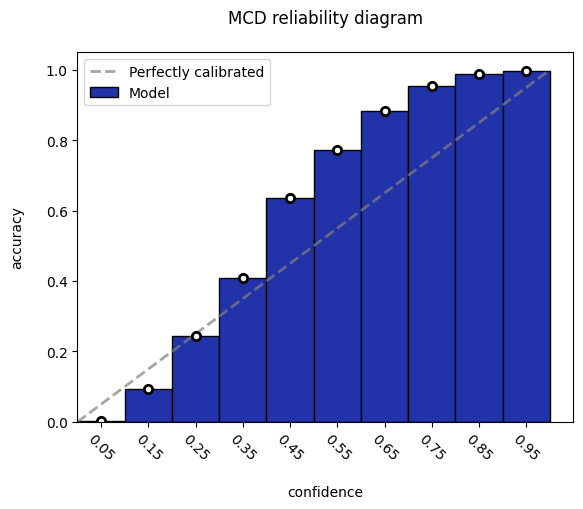

In [21]:
_ = plot_multiclass_calibration_curve(Y_probs, Y, title="MCD reliability diagram")

In [17]:
def predict_ensembles(ensembles: list[keras.Model], x: np.ndarray):
    y_hat_arr = []
    for model in ensembles:
        y_hat = model(x, training=False).numpy()
        y_hat_arr.append(y_hat)

    y_hat_arr = np.stack(y_hat_arr, axis=0)
    y_probs = tf.reduce_mean(y_hat_arr, axis=0).numpy()

    return y_probs

Y_probs_ens = []
Y_ens = []
for x, y in ds_valid:
    y_probs = predict_ensembles(ensembles, x)
    Y_probs_ens.append(np.array(y_probs))
    Y_ens.append(y)

Y_probs_ens = np.concatenate(Y_probs_ens, axis=0)
Y_ens = np.concatenate(Y_ens, axis=0)

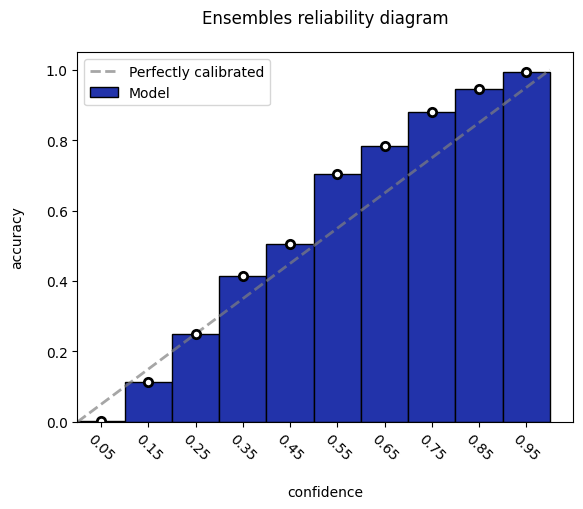

In [20]:
_ = plot_multiclass_calibration_curve(Y_probs_ens, Y_ens, title="Ensembles reliability diagram")

In [27]:
def KL_div(P, Q):
    return -np.sum(P * np.log(Q / P))

In [32]:
P_class = np.sum(Y, axis=0)
P_class = P_class / np.sum(P_class)

In [55]:
P_mcd = P_class[np.argmax(Y, axis=1)]
Q_mcd = np.diag(Y_probs @ Y.T)
kl_mcd = KL_div(P_mcd, Q_mcd)

In [68]:
P_mcd = P_class[np.argmax(Y, axis=1)]
Q_class_mcd = np.eye(len(P_class))[np.argmax(Y_probs, axis=1)]
Q_class_mcd2 = Q_class_mcd / np.sum(Q_class_mcd)
Q_mcd = np.diag(Q_class_mcd @ Q_class_mcd2.T)
kl_mcd = KL_div(P_mcd, Q_mcd)

In [69]:
kl_mcd

np.float64(1277.5829178957079)

In [57]:
P_ens = P_class[np.argmax(Y_ens, axis=1)]
Q_ens = np.diag(Y_probs_ens @ Y_ens.T)
kl_ens = KL_div(P_ens, Q_ens)

In [58]:
kl_ens

np.float32(-668.49066)

In [70]:
P_ens = P_class[np.argmax(Y_ens, axis=1)]
Q_class_ens = np.eye(len(P_class))[np.argmax(Y_probs_ens, axis=1)]
Q_class_ens2 = Q_class_ens / np.sum(Q_class_ens)
Q_ens = np.diag(Q_class_ens @ Q_class_ens.T)
kl_ens = KL_div(P_ens, Q_ens)

In [71]:
kl_ens

np.float64(-784.4307406531395)

In [65]:
np.std(Y_probs, axis=0).mean()

np.float32(0.14920023)

In [64]:
np.std(Y_probs_ens, axis=0).mean()

np.float32(0.15307908)